# BIKE RENTAL DATA MANAGEMENT PORTFOLIO PROJECT

For this project we will explore, clean, and merge Citi Bike ridership and NOAA weather data to produce a PostgreSQL database with analytics-ready views.

## Scenario:

A bike rental company has asked us to create a database to help their analysts understand the effects of weather on bike rentals. We have been given a year of bike rental data from the company and we will source weather data from the government. We will need to clean and validate both data sets, design a relational PostgreSQL database to store the data, and develop views for the database to assist the analytics team.

## Project objectives:

- Use Jupyter notebooks and pandas to explore, clean, and transform datasets
- Design and implement a relational PostgreSQL database
- Use SQL to develop analytics-ready database views
- Complete a portfolio-ready project to showcase your skills!

## Prerequisites:

- Pandas
- SQL
- Knowledge of data cleaning


### Task 1: Prepare the Data

Inspect the data and fix any data quality issues found. Perform any transformations that will be helpful for an analytics team.

There are CSV files containing both Citi Bike data and Weather data. The goal is to both join them and validate that the data in them is good enough to work with. But data cleaning is not linear, so there are many ways to approach this step. Here are some ideas:

- Load and concatenate the Citi Bike CSVs with pandas.concat, then use .head() to get a sense for the data
- Inspect for missing and suspicious data using pandas functions like .describe(), .info(), and .isna().sum()
- Address any data quality issues you find (this could be replacing or flagging missing or suspicious values, fixing typos, or repairing any joins that didn’t work as expected).
- Think about how an analyst would want to interact with the data. Are there any new columns you could create that they might expect?
- Repeat these steps for the weather data



#### Task 1-1: Load and concatenate the Citi Bike CSVs

First, we'll import all files from `data` directory. All files are named `JC-2016**-citibike-tripdata.csv`, where "**" are numbers from 01 to 12 (i.e. `JC-201601-citibike-tripdata.csv`, `JC-201602-citibike-tripdata.csv` and so on).

To do so, we'll use the `glob` module, that finds all the pathnames matching a specified pattern.

In [1]:
import pandas as pd
import glob

# Finding the path for the CSV files
path = 'data/JC-2016*-citibike-tripdata.csv'

# Using `glob` to obtain list of files
all_files = glob.glob(path)

df_list = []

for file in all_files: df_list.append(pd.read_csv(file))

bike_data = pd.concat(df_list, ignore_index=True)
bike_data.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,2084,2016-04-01 00:16:13,2016-04-01 00:50:58,3203,Hamilton Park,40.727596,-74.044247,3209,Brunswick St,40.724176,-74.050656,24500,Subscriber,1979.0,1
1,324,2016-04-01 00:32:48,2016-04-01 00:38:13,3202,Newport PATH,40.727224,-74.033759,3203,Hamilton Park,40.727596,-74.044247,24475,Subscriber,1954.0,1
2,387,2016-04-01 02:00:33,2016-04-01 02:07:00,3220,5 Corners Library,40.734961,-74.059503,3215,Central Ave,40.746730,-74.049251,24503,Subscriber,1975.0,1
3,140,2016-04-01 02:11:43,2016-04-01 02:14:03,3194,McGinley Square,40.725340,-74.067622,3195,Sip Ave,40.730743,-74.063784,24446,Subscriber,1981.0,1
4,142,2016-04-01 02:18:01,2016-04-01 02:20:23,3195,Sip Ave,40.730743,-74.063784,3194,McGinley Square,40.725340,-74.067622,24446,Subscriber,1981.0,1


#### Task 1-2: Inspect and Clean Bike Citi Data

First we'll take a look at the count of rows for each column, to see if there are any NaN values:

In [2]:
bike_data.count()

Trip Duration              247584
Start Time                 247584
Stop Time                  247584
Start Station ID           247584
Start Station Name         247584
Start Station Latitude     247584
Start Station Longitude    247584
End Station ID             247584
End Station Name           247584
End Station Latitude       247584
End Station Longitude      247584
Bike ID                    247584
User Type                  247204
Birth Year                 228585
Gender                     247584
dtype: int64

The columns `User Type` and `Birth Year` show missing data. We will now inspect these columns to better understand the missing data e decide how to treat them. To do so, we will:

- **Count the missing values:** Count the number of missing values in each column and analyze proportion of missing data in relation to the total.
- **Explore missing data:** Verify if missing data follow a pattern (i.e. all data missing in a particular month), and analyze the distribution of non missing data to understand possible cause.
- **Decide missing data tratment:**
    - `User Type`: If missing data proportion is small, we can opt to fill data with a standard value, or remove missing rows.
    - `Birth Year`: We can impute missing values with median values, or remove rows if missing data quantity is significative and there is no clear pattern.

To do so, first we will:

1. Count missing values, and
2. Calculate missing proportions

In [3]:
missing_values = bike_data.isna().sum()
missing_proportion = missing_values / len(bike_data) * 100

print('Missing Values Count:')
print(missing_values) 
print ('------------')
print('Missing Values Proportion:')
print(missing_proportion)

Missing Values Count:
Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station ID               0
Start Station Name             0
Start Station Latitude         0
Start Station Longitude        0
End Station ID                 0
End Station Name               0
End Station Latitude           0
End Station Longitude          0
Bike ID                        0
User Type                    380
Birth Year                 18999
Gender                         0
dtype: int64
------------
Missing Values Proportion:
Trip Duration              0.000000
Start Time                 0.000000
Stop Time                  0.000000
Start Station ID           0.000000
Start Station Name         0.000000
Start Station Latitude     0.000000
Start Station Longitude    0.000000
End Station ID             0.000000
End Station Name           0.000000
End Station Latitude       0.000000
End Station Longitude      0.000000
Bike ID                    0.00000

Analysis show missing data are small for `User Type` (0.15%), but more significative to `Birth Year` (7.67%). We can now use methods such as `.describe()` and `.info()` to get additional insights about the distribution of data and to help better understand missing values, like so:

- **Statistical Summary with `.describe()`:** This method provides an overview of the descriptive statistics for each column, which can help identify outliers or unusual patterns in the data.
- **General Information with `.info()`:** The .info() method shows the data type of each column and the count of non-null values, which can help confirm the presence of missing values.

In [4]:
print('Bike Data Info:')
print(bike_data.info())
print('----------------------')
print('Bike Data Description:')
print(bike_data.describe(include='all'))

Bike Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247584 entries, 0 to 247583
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Trip Duration            247584 non-null  int64  
 1   Start Time               247584 non-null  object 
 2   Stop Time                247584 non-null  object 
 3   Start Station ID         247584 non-null  int64  
 4   Start Station Name       247584 non-null  object 
 5   Start Station Latitude   247584 non-null  float64
 6   Start Station Longitude  247584 non-null  float64
 7   End Station ID           247584 non-null  int64  
 8   End Station Name         247584 non-null  object 
 9   End Station Latitude     247584 non-null  float64
 10  End Station Longitude    247584 non-null  float64
 11  Bike ID                  247584 non-null  int64  
 12  User Type                247204 non-null  object 
 13  Birth Year               228585 non-null  f

#### Insights from the Analysis

**1. `User Type`:**
- There are two unique values: likely "Subscriber" and another type (e.g., "Customer").
- Missing values are minimal (0.15%), suggesting that filling them with a default value like "Unknown" or the mode ("Subscriber") could be reasonable.

**2. `Birth Year`:**
- Missing values are more significant (7.67%).
- The range of years suggests we could use the median or mean for imputation, but further analysis on the distribution might be helpful.

**3. `Gender`:**
- No missing values, values are either 1 or 2. We should confirm what these represent (e.g., 1 = Male, 2 = Female).

But first, let's investigate the unique values in the `User Type` and `Gender` columns to understand what they represent.

In [5]:
user_type_unique = bike_data['User Type'].unique()
gender_unique = bike_data['Gender'].unique()

user_type_unique, gender_unique

(array(['Subscriber', nan, 'Customer'], dtype=object), array([1, 2, 0]))

#### Next Steps for Data Cleaning

1. Handle Missing Values:
    1. User Type: Fill missing values with the mode "Subscriber"
    2. Birth Year: Impute missing values with the median birth year.
2. Convert Start and Stop Times to Datetime:
    1. This will allow us to perform time-based analyses.
3. Create Additional Columns for Analysis:
    1. Extract the hour, day of the week, and month from the datetime columns.

In [6]:
# Computing most frequent (mode) value in the "User Type" column
mode_user_type = bike_data['User Type'].mode()[0]
bike_data['User Type'] = bike_data['User Type'].fillna(mode_user_type)

median_birth_year = bike_data['Birth Year'].median()
bike_data['Birth Year'] = bike_data['Birth Year'].fillna(median_birth_year)

bike_data['Start Time'] = pd.to_datetime(bike_data['Start Time'])
bike_data['Stop Time'] = pd.to_datetime(bike_data['Stop Time'])

bike_data['Start Hour'] = bike_data['Start Time'].dt.hour
bike_data['Start Day'] = bike_data['Start Time'].dt.dayofweek
bike_data['Start Month'] = bike_data['Start Time'].dt.month

print(bike_data.info())
bike_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247584 entries, 0 to 247583
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Trip Duration            247584 non-null  int64         
 1   Start Time               247584 non-null  datetime64[ns]
 2   Stop Time                247584 non-null  datetime64[ns]
 3   Start Station ID         247584 non-null  int64         
 4   Start Station Name       247584 non-null  object        
 5   Start Station Latitude   247584 non-null  float64       
 6   Start Station Longitude  247584 non-null  float64       
 7   End Station ID           247584 non-null  int64         
 8   End Station Name         247584 non-null  object        
 9   End Station Latitude     247584 non-null  float64       
 10  End Station Longitude    247584 non-null  float64       
 11  Bike ID                  247584 non-null  int64         
 12  User Type       

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Start Hour,Start Day,Start Month
0,2084,2016-04-01 00:16:13,2016-04-01 00:50:58,3203,Hamilton Park,40.727596,-74.044247,3209,Brunswick St,40.724176,-74.050656,24500,Subscriber,1979.0,1,0,4,4
1,324,2016-04-01 00:32:48,2016-04-01 00:38:13,3202,Newport PATH,40.727224,-74.033759,3203,Hamilton Park,40.727596,-74.044247,24475,Subscriber,1954.0,1,0,4,4
2,387,2016-04-01 02:00:33,2016-04-01 02:07:00,3220,5 Corners Library,40.734961,-74.059503,3215,Central Ave,40.746730,-74.049251,24503,Subscriber,1975.0,1,2,4,4
3,140,2016-04-01 02:11:43,2016-04-01 02:14:03,3194,McGinley Square,40.725340,-74.067622,3195,Sip Ave,40.730743,-74.063784,24446,Subscriber,1981.0,1,2,4,4
4,142,2016-04-01 02:18:01,2016-04-01 02:20:23,3195,Sip Ave,40.730743,-74.063784,3194,McGinley Square,40.725340,-74.067622,24446,Subscriber,1981.0,1,2,4,4


With the [documentation](data-dictionaries/citibike.pdf) provided, we now know:

- **User Type:**
    - `Customer` = 24-hour pass or 3-day pass user
    - `Subscriber` = Annual Member
- **Gender:**
    - `0` = Unknown
    - `1` = Male
    - `2` = Female

Since we have confirmed the meaning of the gender values, we can proceed with confidence. If gender-based analysis becomes necessary, we can easily interpret the data.

The Bike Data looks clean after handling the missing values and adding the necessary time-based columns. We can move on to cleaning the weather data.

#### Task 1-3: Load the Newark Airport Weather Data CSV

The `newark_airport_2016.csv` file is also in the `data` directory. We can simply read that data and load it into a DataFrame.

In [7]:
weather_data = pd.read_csv('data/newark_airport_2016.csv')

weather_data.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TSUN,WDF2,WDF5,WSF2,WSF5
0,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-01,12.75,NaN,0.0,0.0,0.0,41,43,34,NaN,270,280.0,25.9,35.1
1,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-02,9.40,NaN,0.0,0.0,0.0,36,42,30,NaN,260,260.0,21.0,25.1
2,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-03,10.29,NaN,0.0,0.0,0.0,37,47,28,NaN,270,250.0,23.9,30.0
3,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-04,17.22,NaN,0.0,0.0,0.0,32,35,14,NaN,330,330.0,25.9,33.1
4,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-05,9.84,NaN,0.0,0.0,0.0,19,31,10,NaN,360,350.0,25.1,31.1


From the [provided documentation](data-dictionaries/weather.pdf), we have the following key points regarding the weather data:

**1. Columns and Their Meanings:**

- STATION: Station identification code.
- NAME: Name of the station.
- DATE: Date of the record.
- AWND: Average daily wind speed.
- PGTM: Peak gust time.
- PRCP: Precipitation.
- SNOW: Snowfall.
- SNWD: Snow depth.
- TAVG: Average temperature.
- TMAX: Maximum temperature.
- TMIN: Minimum temperature.
- TSUN: Daily total sunshine.
- WDF2: Direction of fastest 2-minute wind.
- WDF5: Direction of fastest 5-second wind.
- WSF2: Fastest 2-minute wind speed.
- WSF5: Fastest 5-second wind speed.

**2. Handling Missing Data:**

- Missing data is indicated by 9's (e.g., 9999).
- Empty cells indicate that a data observation was not reported.

#### Steps for Cleaning Weather Data:

1. Initial Inspection: Understand the structure and quality of the data.
2. Identify Missing Values: Use `.isna().sum()` to find columns with missing values.
3. Handle Missing Values: Decide on strategies to handle missing values (e.g., fill, drop, or flag).
4. Convert Columns to Appropriate Data Types: Ensure columns like `DATE` are in the correct format.
5. Create Additional Columns if Necessary: Extract any additional useful information.

In [8]:
print('Weather Data Info:')
print(weather_data.info())
print('----------------------')
print('Weather Data Description:')
print(weather_data.describe(include='all'))

Weather Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  366 non-null    object 
 1   NAME     366 non-null    object 
 2   DATE     366 non-null    object 
 3   AWND     366 non-null    float64
 4   PGTM     0 non-null      float64
 5   PRCP     366 non-null    float64
 6   SNOW     366 non-null    float64
 7   SNWD     366 non-null    float64
 8   TAVG     366 non-null    int64  
 9   TMAX     366 non-null    int64  
 10  TMIN     366 non-null    int64  
 11  TSUN     0 non-null      float64
 12  WDF2     366 non-null    int64  
 13  WDF5     364 non-null    float64
 14  WSF2     366 non-null    float64
 15  WSF5     364 non-null    float64
dtypes: float64(9), int64(4), object(3)
memory usage: 45.9+ KB
None
----------------------
Weather Data Description:
            STATION                                         NAME        DAT

In [9]:
missing_values_weather = weather_data.isna().sum()
missing_proportion_weather = missing_values_weather / len(weather_data) * 100

print('Missing Values Count:')
print(missing_values_weather)
print('----------------------')
print('Missing Values Proportion:')
print(missing_proportion_weather)

Missing Values Count:
STATION      0
NAME         0
DATE         0
AWND         0
PGTM       366
PRCP         0
SNOW         0
SNWD         0
TAVG         0
TMAX         0
TMIN         0
TSUN       366
WDF2         0
WDF5         2
WSF2         0
WSF5         2
dtype: int64
----------------------
Missing Values Proportion:
STATION      0.000000
NAME         0.000000
DATE         0.000000
AWND         0.000000
PGTM       100.000000
PRCP         0.000000
SNOW         0.000000
SNWD         0.000000
TAVG         0.000000
TMAX         0.000000
TMIN         0.000000
TSUN       100.000000
WDF2         0.000000
WDF5         0.546448
WSF2         0.000000
WSF5         0.546448
dtype: float64


#### Key Observations

**1. Missing Data:**
- **PGTM (Peak Gust Time)** and **TSUN (Daily Total Sunshine)** are completely missing (100% missing values).
- **WDF5 (Direction of Fastest 5-Second Wind)** and **WSF5 (Fastest 5-Second Wind Speed)** have a small proportion of missing values (~0.55%).

**2. Data Types:**
- **DATE** is currently an object type and should be converted to a datetime type for analysis.

**3. High Standard Deviation:**
- Variables like **TAVG (Average Temperature)**, **TMAX (Maximum Temperature)**, **TMIN (Minimum Temperature)**, **SNOW (Snowfall)**, and **WDF5 (Direction of Fastest 5-Second Wind)** have high standard deviations, indicating significant variability.

**4. Data Span:**
- The data spans the entire year of 2016, confirmed by the 366 rows.

#### Further Steps for Data Cleaning and Analysis

**1. Handle Missing Values:**
- PGTM and TSUN can be dropped from the analysis since they are entirely missing.
- For WDF5 and WSF5, we can decide whether to drop rows with missing values or impute them with appropriate values (e.g., mean, median).

**2. Convert DATE to Datetime:**
- Convert the DATE column to a datetime type to facilitate time-based analysis.

**3. Statistical Summary:**
- Review the statistical summary to understand the range and distribution of values. High standard deviation may warrant further investigation.

**4. Check for Invalid Data:**
- Verify if there are any "9's" used to indicate missing data in other columns.

In [10]:
weather_data.drop(columns=['PGTM', 'TSUN'], inplace=True)

weather_data['WDF5'] = weather_data['WDF5'].fillna(weather_data['WDF5'].mean())
weather_data['WSF5'] = weather_data['WSF5'].fillna(weather_data['WSF5'].mean())

weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

print('Weather Data Info After Cleaning:')
print(weather_data.info())

weather_data.head()

Weather Data Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   STATION  366 non-null    object        
 1   NAME     366 non-null    object        
 2   DATE     366 non-null    datetime64[ns]
 3   AWND     366 non-null    float64       
 4   PRCP     366 non-null    float64       
 5   SNOW     366 non-null    float64       
 6   SNWD     366 non-null    float64       
 7   TAVG     366 non-null    int64         
 8   TMAX     366 non-null    int64         
 9   TMIN     366 non-null    int64         
 10  WDF2     366 non-null    int64         
 11  WDF5     366 non-null    float64       
 12  WSF2     366 non-null    float64       
 13  WSF5     366 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(4), object(2)
memory usage: 40.2+ KB
None


,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-01,12.75,0.0,0.0,0.0,41,43,34,270,280.0,25.9,35.1
1,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-02,9.40,0.0,0.0,0.0,36,42,30,260,260.0,21.0,25.1
2,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-03,10.29,0.0,0.0,0.0,37,47,28,270,250.0,23.9,30.0
3,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-04,17.22,0.0,0.0,0.0,32,35,14,330,330.0,25.9,33.1
4,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2016-01-05,9.84,0.0,0.0,0.0,19,31,10,360,350.0,25.1,31.1


Now, we will Inspect each column to identify if '9's are being used as placeholders for missing data, and use visualizations such as histograms to understand the distribution of columns with high standard deviations.

In [11]:
columns_to_check = ['AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5']

for column in columns_to_check:
    print(f"Values in {column}:")
    print(weather_data[column].value_counts().sort_index())
    print('----------------------')

Values in AWND:
AWND
2.46     1
3.36     1
3.58     1
3.80     5
4.03     2
        ..
19.91    3
20.58    1
21.03    2
21.47    1
22.82    1
Name: count, Length: 70, dtype: int64
----------------------
Values in PRCP:
PRCP
0.00    247
0.01     19
0.02      4
0.03      9
0.04      3
0.05      4
0.07      3
0.08      2
0.09      3
0.10      3
0.11      5
0.12      4
0.13      2
0.14      2
0.16      2
0.17      3
0.20      4
0.21      2
0.22      1
0.23      2
0.26      1
0.27      1
0.29      1
0.31      1
0.36      2
0.37      1
0.38      1
0.39      1
0.42      1
0.44      3
0.46      1
0.48      2
0.49      2
0.50      1
0.51      1
0.52      1
0.55      1
0.57      1
0.59      1
0.61      1
0.62      1
0.65      1
0.71      2
0.87      1
0.92      1
0.94      1
0.99      1
1.02      1
1.03      1
1.07      1
1.57      1
1.77      1
1.81      1
1.84      1
2.02      1
2.79      1
Name: count, dtype: int64
----------------------
Values in SNOW:
SNOW
0.0     350
0.1       1
0.2       

Based on the value counts for each column, it appears that there are no placeholder values such as '9's being used to indicate missing data. All the values seem to fall within the expected ranges for their respective columns.

Since we've confirmed there are no placeholder values and have handled the initial data cleaning, we can proceed to investigate the variability in columns with high standard deviations. This will help us understand the distribution of these values and identify any potential outliers or unusual patterns.

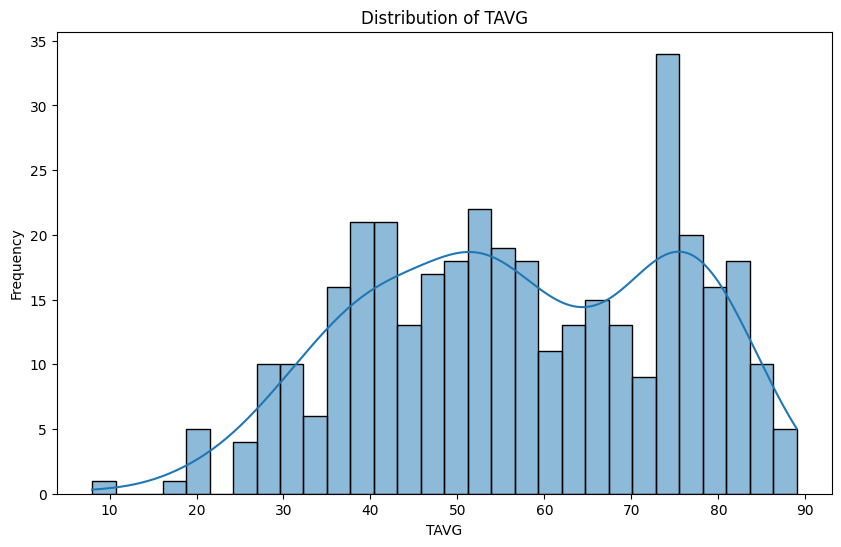

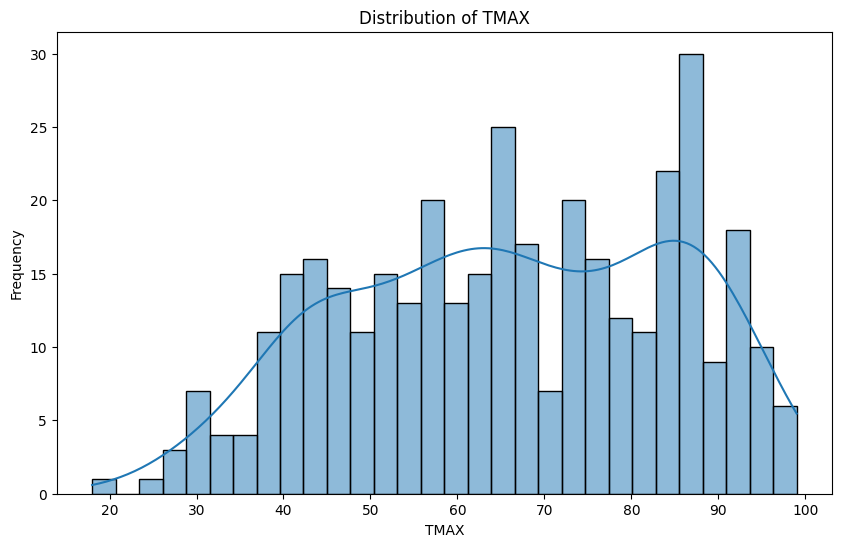

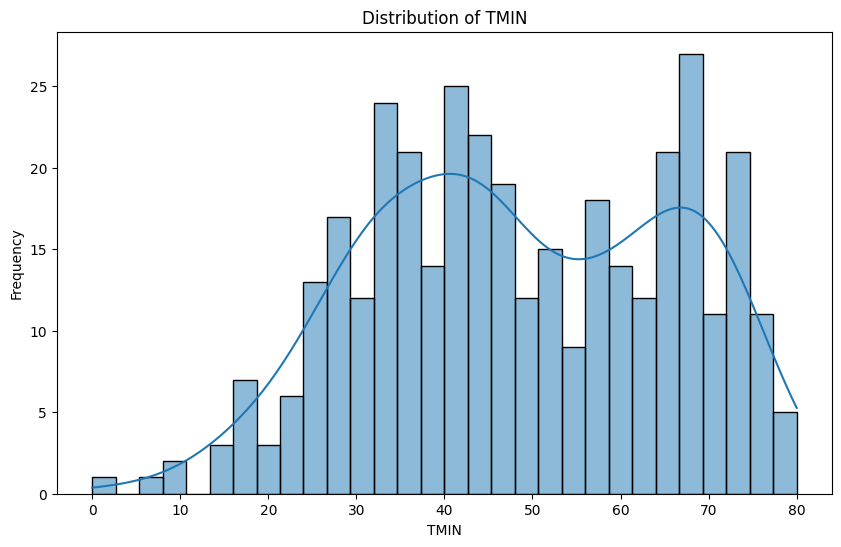

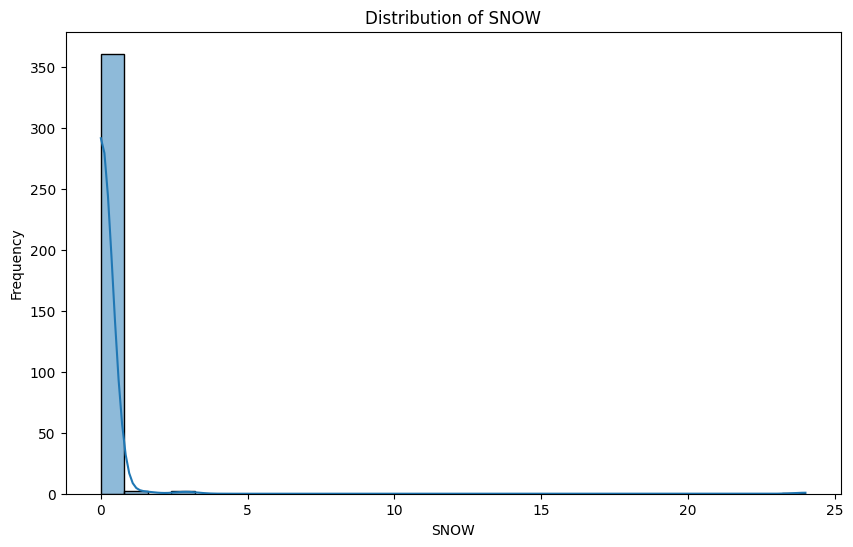

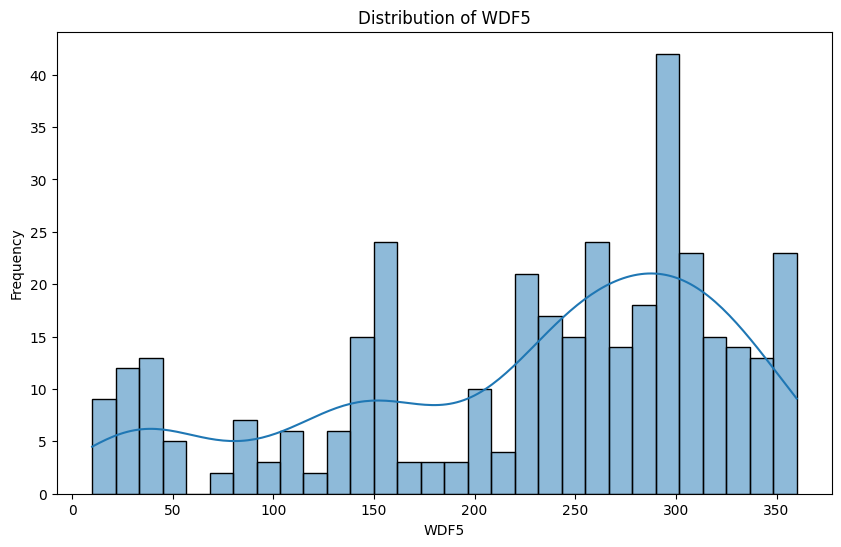

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_with_high_std = ['TAVG', 'TMAX', 'TMIN', 'SNOW', 'WDF5']

for column in columns_with_high_std:
    plt.figure(figsize=(10,6))
    sns.histplot(weather_data[column], bins=30, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    plt.close()

Based on the histograms:

- The TAVG (Average Temperature) distribution is fairly uniform, with some peaks, indicating a wide range of average temperatures over the year.
- The TMAX (Maximum Temperature) distribution is also fairly uniform with a slight skew towards higher temperatures, indicating that there are more days with higher maximum temperatures.
- The TMIN (Minimum Temperature) distribution shows a wide range with some clustering around certain temperatures, indicating variability in minimum temperatures throughout the year.
- The SNOW (Snowfall) distribution is heavily skewed towards zero, indicating that snowfall is infrequent. There are a few days with significant snowfall, which are outliers.
- The WDF5 (Direction of Fastest 5-Second Wind) distribution is spread out, indicating that wind direction varies widely.

Overall, the distributions seem reasonable and align with typical weather data variability. The skewness in some columns, especially SNOW, is expected as certain weather events (like snowfall) are not frequent.

This concludes the first task of preparing the data.

### Task 2: Create a Schema

Create a schema for the final database. This schema should include every table you plan to implement (feel free to split up the existing `DataFrames`), all data types, and all primary/foreign key relationships.

There are many tools available for creating a schema, but ultimately this can be accomplished with just pen and paper. Here are some prompts:

- What are the different components of a trip (e.g. `stations`), and how could those be split into relational tables?
- Think about updating, inserting, and deleting data. Are there any problems (like the same data stored in multiple tables or rows) that need to be addressed?
- What columns will be in each table, and what should their data types be?
- Make sure each table has a primary key, and all foreign key relationships are mapped in the schema.

Creating a schema for the final database involves identifying the main entities in our dataset and structuring them into relational tables. Based on our data, we can identify the following main components:

- **Trips:** Information about each bike trip.
- **Stations:** Details about the start and end stations.
- **Bikes:** Information about the bikes used.
- **Users:** Information about the users who rented the bikes.
- **Weather:** Weather data for each day.

![image.png](db-schema.png)

### Task 3: Create the Database

Implement the schema in a Postgres database and insert the data.

- Create the database using postbird (or your preferred client)
- Create the tables from your schema using SQL CREATE TABLE commands executed via postbird
- Use pandas to generate each table’s data from the cleaned `DataFrames`
- Use pandas and SQLAlchemy to insert the data into each table in the database

To complete task 3, first we will start a PostgreSQL service. Since we're completing this project on Linux Ubuntu, we will run the following command on bash:

```bash
sudo service postgresql start
```

Then we open PostgreSQL shell:

```bash
sudo -i -u postgres
psql
```

In the PostgreSQL shell we can create a new database:

```sql
CREATE DATABASE bike_rental;
```

And connect the new database:

```sql
\c bike_rental
```

Now we can connect to the PostgreSQL database using [SQLAlchemy](https://www.sqlalchemy.org/) and execute SQL commands to create the tables.

SQLAlchemy is the Python SQL toolkit and Object Relational Mapper that gives application developers the full power and flexibility of SQL. 

In [1]:
import os

print("DB_USER:", os.getenv('PGUSER'))
print("DB_PASSWORD:", os.getenv('PGPASSWORD'))
print("DB_NAME:", os.getenv('PGDATABASE'))
print("DB_HOST:", os.getenv('PGHOST'))
print("DB_PORT:", os.getenv('PGPORT'))

DB_USER: postgres
DB_PASSWORD: 19650917idkfA!
DB_NAME: default_db
DB_HOST: localhost
DB_PORT: 5432


In [ ]:
import psycopg2

try:
    conn = psycopg2.connect(
        dbname=os.getenv('PGDATABASE'),
        user=os.getenv('PGUSER'),
        password=os.getenv('PGPASSWORD'),
        host=os.getenv('PGHOST'),
        port=os.getenv('PGPORT')
    )
    print("Connection successful")
    conn.close()
except Exception as e:
    print("Connection failed:", e)

In [ ]:
import os
from sqlalchemy import create_engine

# Access PostgreSQL default environment variables
DB_USER = os.getenv('PGUSER')
DB_PASSWORD = os.getenv('PGPASSWORD')
DB_NAME = os.getenv('PGDATABASE')
DB_HOST = os.getenv('PGHOST')
DB_PORT = os.getenv('PGPORT')

# Create the SQLAlchemy engine
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Verify the connection
with engine.connect() as connection:
    result = connection.execute("SELECT 1")
    print(result.fetchone())